In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import fetch_openml

In [137]:
adult = fetch_openml(name='adult', version=2)

In [127]:
for key, val in adult.items():
    print('-'*100)
    print(key)
    print('-'*100)
    print(val)
    print()

----------------------------------------------------------------------------------------------------
data
----------------------------------------------------------------------------------------------------
        age     workclass    fnlwgt     education  education-num  \
0      25.0       Private  226802.0          11th            7.0   
1      38.0       Private   89814.0       HS-grad            9.0   
2      28.0     Local-gov  336951.0    Assoc-acdm           12.0   
3      44.0       Private  160323.0  Some-college           10.0   
4      18.0           NaN  103497.0  Some-college           10.0   
...     ...           ...       ...           ...            ...   
48837  27.0       Private  257302.0    Assoc-acdm           12.0   
48838  40.0       Private  154374.0       HS-grad            9.0   
48839  58.0       Private  151910.0       HS-grad            9.0   
48840  22.0       Private  201490.0       HS-grad            9.0   
48841  52.0  Self-emp-inc  287927.0       HS-

In [128]:
print(adult['feature_names'])

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


In [129]:
adult['frame']['class'].value_counts()

<=50K    37155
>50K     11687
Name: class, dtype: int64

In [130]:
adult['frame']['sex'].value_counts()

Male      32650
Female    16192
Name: sex, dtype: int64

In [131]:
df = adult['frame']
attr = 'marital-status'
df_temp = []
df_temp2 = []
for attr_val in df[attr].unique():
    s = df[df[attr] == attr_val]['class'].value_counts(normalize=True).rename(attr_val)
    s.index = s.index.astype(str)
    cnt = len(df[df[attr] == attr_val])
    s['cnt'] = cnt
    df_temp.append(s)
df_temp = pd.concat(df_temp, axis=1).T
df_temp.sort_values(by='>50K')

,<=50K,>50K,cnt
Never-married,0.954520,0.045480,16117.0
Separated,0.935294,0.064706,1530.0
Widowed,0.915679,0.084321,1518.0
Married-spouse-absent,0.907643,0.092357,628.0
Divorced,0.898839,0.101161,6633.0
Married-AF-spouse,0.621622,0.378378,37.0
Married-civ-spouse,0.553867,0.446133,22379.0


In [148]:
def get_target_frac(df, attrs, target_attr, target_attr_val, col_name):
    '''
    Return a dataframe with index on attrs and column about the fraction of target_attr_val 
    appearing in the target_attr column grouped by the attrs.
    '''
    res = df[df[target_attr] == target_attr_val].groupby(attrs).size().to_frame(col_name) 
    res[col_name] /= df.groupby(attrs).size()
    return res
    
def what_if_removed(df, control_attr, dependent_attr, target_attr, target_attr_val, index=None):
    target_frac_concatted = []
    
    # First, get the target fraction for all the control_attr
    target_frac_origin = get_target_frac(df, control_attr, target_attr, target_attr_val, 'origin')
    target_frac_concatted.append(target_frac_origin)
    for dependent_attr_val in df[dependent_attr].unique():
        df_what_if_removed = df.query(f'`{dependent_attr}` != "{dependent_attr_val}"') 
        target_frac_dependent = get_target_frac(df_what_if_removed, control_attr, target_attr, target_attr_val, dependent_attr_val)
        target_frac_concatted.append(target_frac_dependent)
    
    target_frac_concatted = pd.concat(target_frac_concatted, axis=1)
    if index:
        target_frac_concatted = target_frac_concatted.reindex(index)
    return target_frac_concatted

In [149]:
print(adult['feature_names'])

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


In [158]:
control_attr = 'education'
index = ['Prof-school', 'Doctorate']
dependent_attr = 'marital-status'
target_attr = 'class'
target_attr_val = '>50K'
df = adult['frame'].copy()
df['age'] = pd.cut(df['age'], bins=np.linspace(0, 100, 11).astype(int)).astype('str')
what_if_removed(df, control_attr, dependent_attr, target_attr, target_attr_val, index)

,origin,Never-married,Married-civ-spouse,Widowed,Divorced,Separated,Married-spouse-absent,Married-AF-spouse
education,,,,,,,,
Prof-school,0.739808,0.801439,0.474790,0.742718,0.760526,0.740606,0.741858,0.739496
Doctorate,0.725589,0.780684,0.518325,0.728055,0.736059,0.730703,0.729776,0.725126


# Why Prof-school has higher high-income rate than Doctorate?

* Reason 1. marital-status = "Married-civ-spouse". It might be due to that a married prof-school earns more than a married doctorate. 

* Reason 2. occupation = "Prof-specialty". It might be due to that a prof-school tends to have a higher pay in a position of "Porf-specialty" than a doctorate.

* Reason 3. workclass = "Self-emp-not-inc" or "Self-emp-inc". It might be due to that a prof-school tends to earn more if s/he is self-employed.

* Reason 4. relationship = "Husband". It might be due to that a husband with prof-school degree tends to earn more than a huasband with doctorate degree.

* Reason 5. race = "White". It might be due that a white person with prof-school degree tends to earn more than a white person with doctorate degree. Or we say, if we don't take white people into account, prof-school degree tends to earn less than doctorate degree.

* Reason 6. sex = "Male".

* Reason 7. native_country = "United-States". 

* Reason 8. age = (30, 40] or (40, 50]. 

In [75]:
control_attr = 'workclass'
dependent_attr = 'marital-status'
target_attr = 'class'
target_attr_val = '>50K'
df = adult['frame']

pivot = (df[df[target_attr] == target_attr_val]
            .groupby([control_attr, dependent_attr]).size().to_frame(target_attr_val)
        )
pivot[target_attr_val] /= df.groupby([control_attr, dependent_attr]).size()#.to_frame('total')
pivot = pd.pivot_table(
    pivot.reset_index(),
    values=target_attr_val,
    index=control_attr,
    columns=dependent_attr,
    aggfunc='sum'
)
pivot

marital-status,Married-civ-spouse,Divorced,Never-married,Separated,Widowed,Married-spouse-absent,Married-AF-spouse
workclass,,,,,,,
Private,0.433981,0.091238,0.039860,0.064343,0.079596,0.079470,0.416667
Self-emp-not-inc,0.355129,0.155093,0.119086,0.035294,0.118110,0.208333,0.666667
Self-emp-inc,0.670886,0.260274,0.142180,0.240000,0.365854,0.125000,0.000000
Federal-gov,0.653259,0.151261,0.097826,0.179487,0.125000,0.200000,0.666667
Local-gov,0.511719,0.109641,0.077694,0.080000,0.071429,0.090909,0.000000
State-gov,0.506742,0.107595,0.051887,0.046154,0.106383,0.160000,0.000000
Without-pay,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Never-worked,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [76]:
# https://smallbiztrends.com/2013/11/incorporated-versus-unincorporated-self-employment.html

In [154]:
df = adult['frame'].copy()
df['age'] = pd.cut(df['age'], bins=np.linspace(0, 100, 11).astype(int)).astype('str')

In [156]:
df.to_csv('adult.csv', index=False)

In [157]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,"(20, 30]",Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,"(30, 40]",Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,"(20, 30]",Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,"(40, 50]",Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,"(10, 20]",NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,"(20, 30]",Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
48838,"(30, 40]",Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
48839,"(50, 60]",Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
48840,"(20, 30]",Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K


In [162]:
for col in df.columns:
    print(col + ',')

age,
workclass,
fnlwgt,
education,
education-num,
marital-status,
occupation,
relationship,
race,
sex,
capital-gain,
capital-loss,
hours-per-week,
native-country,
class,


In [168]:
df.query('relationship=="Own-child" ').education.value_counts()

Some-college    2573
HS-grad         2287
Bachelors        774
11th             651
10th             326
12th             239
Assoc-voc        212
Assoc-acdm       198
9th              108
Masters           82
7th-8th           66
5th-6th           19
Prof-school       17
Doctorate         11
1st-4th           11
Preschool          7
Name: education, dtype: int64

In [169]:
len(df)

48842

In [172]:
df.groupby('marital-status')#['label'].value_counts()

In [198]:
taxi_df = pd.read_csv('preprocessed_yellow_tripdata_2019-02.csv')

In [199]:
taxi_df.columns

Index(['PU_Zone', 'PU_Borough', 'PU_Hour', 'PU_WeekDay', 'DO_Zone',
       'DO_Borough', 'DO_Hour', 'DO_WeekDay', 'payment_type', 'trip_speed',
       'trip_distance', 'trip_time', 'total_amount', 'tip_amount'],
      dtype='object')

In [200]:
taxi_df.query('PU_Borough == "Queens"')['PU_Zone'].unique()

array(['JFK Airport', 'LaGuardia Airport', 'Jackson Heights', 'Astoria',
       'Long Island City/Hunters Point', 'Sunnyside', 'Rego Park',
       'Baisley Park', 'Queensbridge/Ravenswood',
       'Long Island City/Queens Plaza', 'Bay Terrace/Fort Totten',
       'Saint Albans', 'Springfield Gardens North', 'Bayside',
       'Old Astoria', 'Flushing', 'Elmhurst', 'East Elmhurst',
       'Springfield Gardens South', 'Jamaica', 'South Ozone Park',
       'Steinway', 'Jamaica Estates', 'Far Rockaway', 'Woodside',
       'Whitestone', 'South Jamaica', 'Flushing Meadows-Corona Park',
       'Ridgewood', 'Briarwood/Jamaica Hills', 'Forest Hills',
       'Cambria Heights', 'Hillcrest/Pomonok', 'Hollis',
       'Oakland Gardens', 'Howard Beach', 'Fresh Meadows',
       'Kew Gardens Hills', 'Richmond Hill', 'Elmhurst/Maspeth',
       'Astoria Park', 'Ozone Park', 'Hammels/Arverne', 'Kew Gardens',
       'North Corona', 'Woodhaven', 'Rosedale', 'Corona',
       'Saint Michaels Cemetery/Woodside'

In [201]:
len(taxi_df.query('PU_Borough == "Queens"')['PU_Zone'].unique())

68

In [202]:
taxi_df['PU_Borough'].unique()

array(['Manhattan', 'Queens', 'Brooklyn', 'Bronx', 'Unknown', 'EWR',
       'Staten Island'], dtype=object)

<AxesSubplot:xlabel='trip_time', ylabel='Count'>

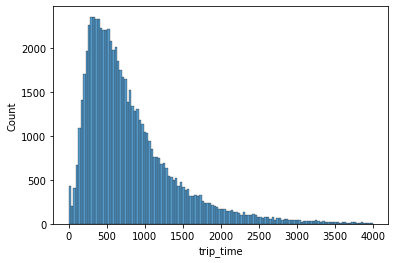

In [208]:
sns.histplot(taxi_df.query('trip_time < 4000').sample(frac=0.01).trip_time)

<AxesSubplot:xlabel='trip_distance', ylabel='Count'>

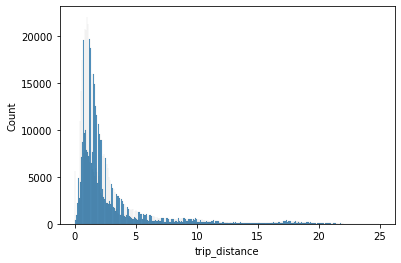

In [214]:
sns.histplot(taxi_df.query('trip_distance < 25').sample(frac=0.1).trip_distance)

<AxesSubplot:xlabel='tip_amount', ylabel='Count'>

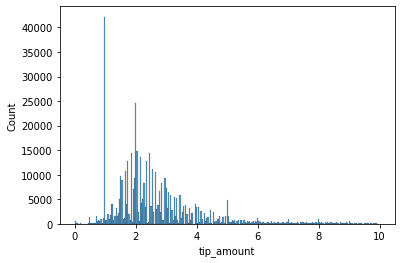

In [223]:
sns.histplot(taxi_df.query('0 < tip_amount < 10').sample(frac=0.1).tip_amount)

<AxesSubplot:xlabel='total_amount', ylabel='Count'>

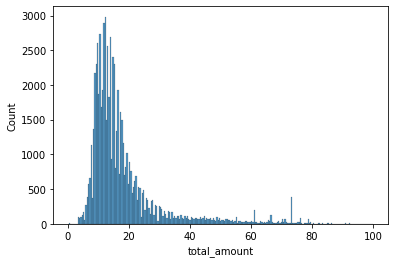

In [220]:
sns.histplot(taxi_df.query('0 < total_amount < 100').sample(frac=0.01).total_amount)

In [203]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
'display.max_colwidth', 1000):
    print(
        taxi_df
        .query('PU_Borough == "Queens"')
        .groupby('PU_Zone')
        .agg(speed=('trip_speed', 'mean'), count=('trip_speed', 'count'))
        .sort_values(by='speed')
    )

                                         speed   count
PU_Zone                                               
Saint Michaels Cemetery/Woodside      5.712039     270
Queensbridge/Ravenswood               8.048449    4982
Breezy Point/Fort Tilden/Riis Beach   9.791960       2
Long Island City/Hunters Point       10.805988    9058
Astoria                              13.134548   10256
Sunnyside                            13.521296   10566
Long Island City/Queens Plaza        13.605768    6229
Old Astoria                          13.734209    3605
Ozone Park                           13.950621     222
Elmhurst/Maspeth                     14.166775     682
Ridgewood                            14.312817     318
Woodside                             14.512856    3478
Elmhurst                             14.628940    2174
Jackson Heights                      14.672728    3354
North Corona                         14.767881     318
Glendale                             15.690449     169
Forest Hil

In [204]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
'display.max_colwidth', 1000):
    print(
        taxi_df
        .query('PU_Borough == "Queens"')
        .groupby('PU_Zone')
        .agg(answer=('trip_time', 'mean'), count=('trip_time', 'count'))
        .sort_values(by='answer')
    )

                                          answer   count
PU_Zone                                                 
Long Island City/Hunters Point        671.156541    9135
Queensbridge/Ravenswood               764.942903    5009
Astoria                               790.494497   10267
Saint Michaels Cemetery/Woodside      849.205128     273
Long Island City/Queens Plaza         864.914529    6236
Bellerose                             939.411765     170
Elmhurst/Maspeth                      976.455344     683
Old Astoria                          1056.202995    3606
Woodside                             1070.949756    3483
Sunnyside                            1126.579505   10578
Steinway                             1152.294948    3187
Breezy Point/Fort Tilden/Riis Beach  1205.000000       2
Middle Village                       1206.420732     164
Rego Park                            1226.107500     800
East Flushing                        1227.305085      59
Elmhurst                       

In [209]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
'display.max_colwidth', 1000):
    print(
        taxi_df
        .query('PU_Borough == "Queens"')
        .groupby('PU_Zone')
        .agg(answer=('trip_distance', 'mean'), count=('trip_distance', 'count'))
        .sort_values(by='answer')
    )

                                        answer   count
PU_Zone                                               
Queensbridge/Ravenswood               1.738694    5009
Saint Michaels Cemetery/Woodside      1.748974     273
Long Island City/Hunters Point        2.419366    9135
Astoria                               2.751045   10267
Long Island City/Queens Plaza         2.853853    6236
Breezy Point/Fort Tilden/Riis Beach   3.010000       2
Old Astoria                           3.109032    3606
Woodside                              3.558007    3483
Elmhurst/Maspeth                      3.651816     683
Sunnyside                             3.664370   10578
Jackson Heights                       3.802480    3359
Elmhurst                              3.928787    2176
Steinway                              4.678434    3187
Rego Park                             4.899975     800
Astoria Park                          4.919888      89
North Corona                          5.611195     318
Middle Vil

In [221]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
'display.max_colwidth', 1000):
    print(
        taxi_df
        .query('PU_Borough == "Queens"')
        .groupby('PU_Zone')
        .agg(answer=('total_amount', 'mean'), count=('total_amount', 'count'))
        .sort_values(by='answer')
    )

                                        answer   count
PU_Zone                                               
Queensbridge/Ravenswood               9.750020    5009
Saint Michaels Cemetery/Woodside     11.080403     273
Astoria                              14.166380   10267
Old Astoria                          15.500527    3606
Long Island City/Queens Plaza        15.600364    6236
Jackson Heights                      18.077630    3359
Elmhurst/Maspeth                     18.852650     683
Breezy Point/Fort Tilden/Riis Beach  19.300000       2
Long Island City/Hunters Point       19.486667    9135
Woodside                             20.469245    3483
Sunnyside                            21.134508   10578
Elmhurst                             22.151889    2176
Bellerose                            22.304882     170
East Flushing                        23.105593      59
North Corona                         23.492013     318
Rego Park                            24.794962     800
Forest Hil

In [224]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
'display.max_colwidth', 1000):
    print(
        taxi_df
        .query('PU_Borough == "Queens"')
        .groupby('PU_Zone')
        .agg(answer=('tip_amount', 'mean'), count=('tip_amount', 'count'))
        .sort_values(by='answer')
    )

                                       answer   count
PU_Zone                                              
Breezy Point/Fort Tilden/Riis Beach  0.000000       2
Broad Channel                        0.000000       5
Saint Albans                         0.031101     690
Springfield Gardens North            0.042021     574
Laurelton                            0.052811     249
Hollis                               0.067114     149
Auburndale                           0.089203     138
Far Rockaway                         0.135362     138
Hammels/Arverne                      0.203763      93
Woodhaven                            0.207726     299
Queens Village                       0.220752     492
Bay Terrace/Fort Totten              0.221007     139
Bayside                              0.223475     259
Cambria Heights                      0.246601     203
Kew Gardens Hills                    0.264831     532
Queensboro Hill                      0.271761     159
Fresh Meadows               

In [229]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
'display.max_colwidth', 1000):
    print(
        taxi_df
        #.query('PU_Borough == "Queens"')
        .groupby('PU_Borough')
        .agg(answer=('trip_time', 'mean'), count=('trip_time', 'count'))
        .sort_values(by='answer')
    )

                    answer    count
PU_Borough                         
EWR             139.995918      490
Unknown         827.480825    74314
Manhattan       955.628091  6407430
Brooklyn       1259.132081    88022
Bronx          1513.237958    14969
Queens         2069.717448   433818
Staten Island  2107.731928      332


In [228]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
'display.max_colwidth', 1000):
    print(
        taxi_df
        #.query('PU_Borough == "Queens"')
        .groupby('PU_Borough')
        .agg(answer=('total_amount', 'mean'), count=('total_amount', 'count'))
        .sort_values(by='answer')
    )

                  answer    count
PU_Borough                       
Manhattan      16.495894  6407430
Brooklyn       20.514704    88022
Unknown        21.429046    74314
Bronx          26.217393    14969
Queens         47.737244   433818
Staten Island  50.969247      332
EWR            90.458163      490


In [225]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
'display.max_colwidth', 1000):
    print(
        taxi_df
        #.query('PU_Borough == "Queens"')
        .groupby('PU_Borough')
        .agg(answer=('tip_amount', 'mean'), count=('tip_amount', 'count'))
        .sort_values(by='answer')
    )

                  answer    count
PU_Borough                       
Bronx           0.291616    14969
Staten Island   0.826265      332
Brooklyn        1.428248    88022
Manhattan       1.949915  6407430
Unknown         2.366311    74314
Queens          5.482766   433818
EWR            11.661816      490


In [226]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
'display.max_colwidth', 1000):
    print(
        taxi_df
        #.query('PU_Borough == "Queens"')
        .groupby('DO_Borough')
        .agg(answer=('tip_amount', 'mean'), count=('tip_amount', 'count'))
        .sort_values(by='answer')
    )

                  answer    count
DO_Borough                       
Bronx           1.601121    51328
Manhattan       1.978127  6258354
Unknown         3.239568    78529
Brooklyn        3.396764   293253
Queens          4.067356   324084
Staten Island   5.176740     2089
EWR            12.173364    11738


In [227]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
'display.max_colwidth', 1000):
    print(
        taxi_df
        #.query('PU_Borough == "Queens"')
        .groupby('PU_Zone')
        .agg(answer=('tip_amount', 'mean'), count=('tip_amount', 'count'))
        .sort_values(by='answer')
    )

                                                  answer   count
PU_Zone                                                         
Rossville/Woodrow                               0.000000       4
Arden Heights                                   0.000000      19
Crotona Park                                    0.000000      21
New Dorp/Midland Beach                          0.000000       3
Eltingville/Annadale/Prince's Bay               0.000000      10
Broad Channel                                   0.000000       5
Breezy Point/Fort Tilden/Riis Beach             0.000000       2
Co-Op City                                      0.025267     619
Woodlawn/Wakefield                              0.031070     271
Saint Albans                                    0.031101     690
Springfield Gardens North                       0.042021     574
Eastchester                                     0.042928     304
Brownsville                                     0.048969     912
Laurelton                